# canny_edge_detection_implementation

- Noise reduction
- Gradient calculation
- Non-maximum suppression
- Double threshold
- Edge Tracking by Hysteresis

In [2]:
from __future__ import print_function
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
from config import CURRENT_DIR
from scipy.ndimage.filters import convolve as convolveimg

IMG_PATH = os.path.join(CURRENT_DIR, "lena.png")

In [3]:
lena_img_bgr = cv2.imread(IMG_PATH)
lena_img_rgb = cv2.cvtColor(lena_img_bgr, cv2.COLOR_BGR2RGB)
lena_img_gray = cv2.cvtColor(lena_img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)

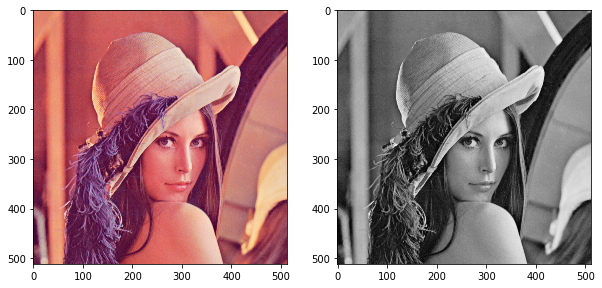

In [4]:
figure, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(lena_img_rgb)
axes[1].imshow(lena_img_gray, cmap="gray")

# noise reduction

\begin{align}
H_{ij} = \frac{1}{2 \pi {\sigma}^2} \exp(-\frac{(i - (k+1))^2 + (j - (k+1))^2}{2{\sigma}^2});
1 <= i, j <= (2k+1)
\end{align}

In [5]:
def gaussian_kernel(size, sigma=1):
    assert(isinstance(size, int))
    assert(size % 2 == 1)
    half_size = size / 2
    x, y = np.mgrid[-half_size:half_size+1, -half_size:half_size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

used_gaussian_kernel = gaussian_kernel(5, 6)

blurred_lena_img = cv2.filter2D(lena_img_gray, -1, used_gaussian_kernel)
# blurred_lena_img = cv2.GaussianBlur(lena_img_gray,(5,5),0)

# gradient calculation

\begin{align}
K_x = 
        \begin{bmatrix}
            -1 & 0 & 1 \\
            -2 & 0 & 2 \\
            -1 & 0 & 1
        \end{bmatrix}
        ;
K_y = 
        \begin{bmatrix}
            1 & 2 & 1 \\
             0 & 0 & 0 \\
            -1 & -2 & -1
        \end{bmatrix}
        \\
\end{align}

\begin{align}
|G| = \sqrt{(G_x^2 + G_y^2)}\\
\theta(x, y) = arctan(\frac{G_y}{G_x})
\end{align}


In [6]:
def sobel_x(img):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    
    I_x = convolveimg(img, kernel_x)
    return I_x

def sobel_y(img):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    I_y = convolveimg(img, kernel_y)
    return I_y

def sobel_filter(img):
    assert(img.ndim == 2)
    I_x = sobel_x(lena_img_gray)
    I_y = sobel_y(lena_img_gray)

    I = np.hypot(I_x, I_y)
    
    assert(I.max() > 0)
    I = I / I.max() * 255
    theta = np.arctan2(I_y, I_x)   
    return (I, theta)

gradient_img, theta = sobel_filter(lena_img_gray)
assert(gradient_img.dtype == np.float32)


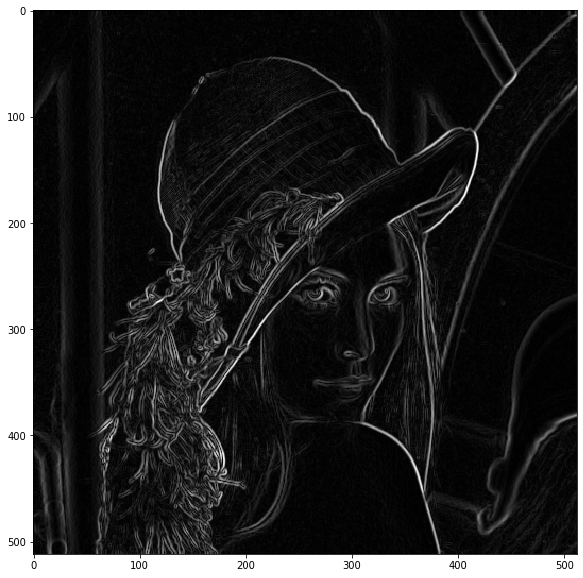

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(gradient_img, cmap="gray")

# Non-maximum suppression

In [8]:
def non_max_suppression(gray_img, theta):
    assert gray_img.shape == theta.shape
    assert gray_img.ndim == 2
    Z = np.copy(gray_img)
    HEIGHT, WIDTH = gray_img.shape

    PI_over_8 = np.pi / 8

    for i in range(1, HEIGHT - 1):
        for j in range(1, WIDTH - 1):
            direction = theta[i, j]
            # angle 0
            if (0 <= direction < PI_over_8) or (
                15 * PI_over_8 <= direction <= 2 * np.pi
            ):
                q = gray_img[i, j + 1]
                r = gray_img[i, j - 1]
            # angle 45
            elif (PI_over_8 <= direction < 3 * PI_over_8) or (
                9 * PI_over_8 <= direction < 11 * PI_over_8
            ):
                q = gray_img[i + 1, j - 1]
                r = gray_img[i - 1, j + 1]
            # angle 90
            elif (3 * PI_over_8 <= direction < 5 * PI_over_8) or (
                11 * PI_over_8 <= direction < 13 * PI_over_8
            ):
                q = gray_img[i + 1, j]
                r = gray_img[i - 1, j]
            else:
                q = gray_img[i - 1, j - 1]
                r = gray_img[i + 1, j + 1]

            if (gray_img[i, j] < q) or (gray_img[i, j] < r):
                Z[i, j] = 0

    return Z


In [9]:
nms = non_max_suppression(gradient_img, theta)

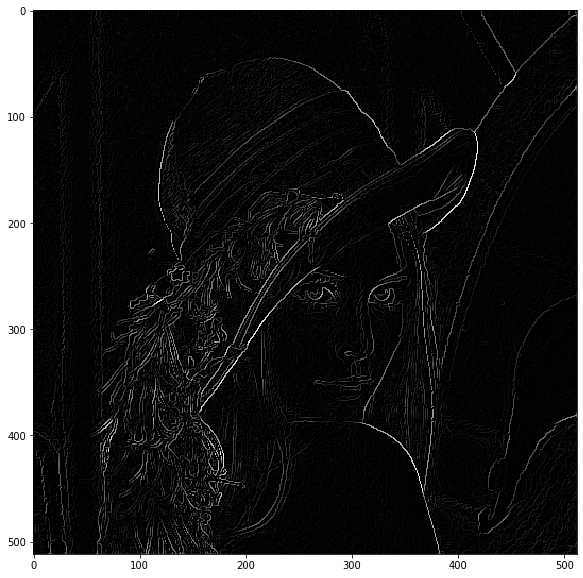

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(nms, cmap="gray")

# Double threshold

classify each pixel into strong pixel, weak pixel and non-relevant pixel using 2 threshold value

In [11]:
import enum

class THRESHOLD_PIXEL(enum.Enum):
    NON_RELEVANT = 0
    STRONG = 1
    WEAK = 2


def thresholding(
    img,
    low_threshold_ratio=0.07,
    high_threshold_ratio=0.19,
):
    assert img.ndim == 2
    high_threshold = img.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio

    res = np.zeros(img.shape, dtype=np.uint8)

    res[np.where(img >= high_threshold)] = THRESHOLD_PIXEL.STRONG.value
    res[np.where((img <= high_threshold) & (img >= low_threshold))] = THRESHOLD_PIXEL.WEAK.value

    return res

thresholded = thresholding(nms)

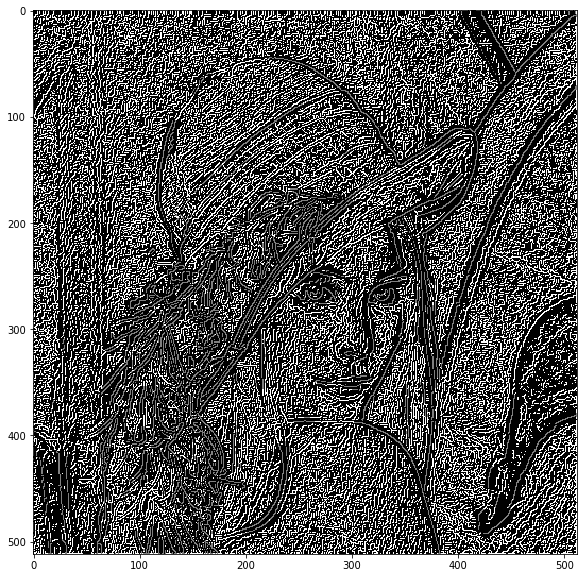

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(thresholded, cmap="gray")

# Edge Tracking by Hysteresis

In [13]:
def eight_neighbors(row, col):
    indices = []
    for i in (-1, 0, 1):
        for j in (-1, 0, 1):
            if (i == 0 and j == 0):
                continue
            indices.append((row + i, col + j))
    return indices

def hysteresis(thresholded):
    assert(thresholded.ndim == 2)
    HEIGHT, WIDTH = thresholded.shape
    
    hysteresis_thresholded = np.copy(thresholded)
    for ir in range(1, HEIGHT - 1):
        for ic in range(1, WIDTH - 1):
            if (thresholded[ir, ic] != THRESHOLD_PIXEL.WEAK.value):
                continue
            
            for idx in eight_neighbors(ir, ic):
                if (thresholded[idx[0], idx[1]] == THRESHOLD_PIXEL.STRONG.value):
                    hysteresis_thresholded[ir, ic] = THRESHOLD_PIXEL.STRONG.value
                    break
                    
            if (hysteresis_thresholded[ir, ic] == THRESHOLD_PIXEL.WEAK.value):
                hysteresis_thresholded[ir, ic] = THRESHOLD_PIXEL.NON_RELEVANT.value
                
                
    return hysteresis_thresholded
                        

    

In [14]:
def hysteresis_img(thresholded, weak_value=25, strong_value=255):
    result = np.copy(thresholded)
    
    hysteresis_thresholded = hysteresis(thresholded)
    result[np.where(hysteresis_thresholded == THRESHOLD_PIXEL.STRONG.value)] = strong_value
    result[np.where(hysteresis_thresholded == THRESHOLD_PIXEL.WEAK.value)] = weak_value
    
    return result

In [15]:
edged_img = hysteresis_img(thresholded)

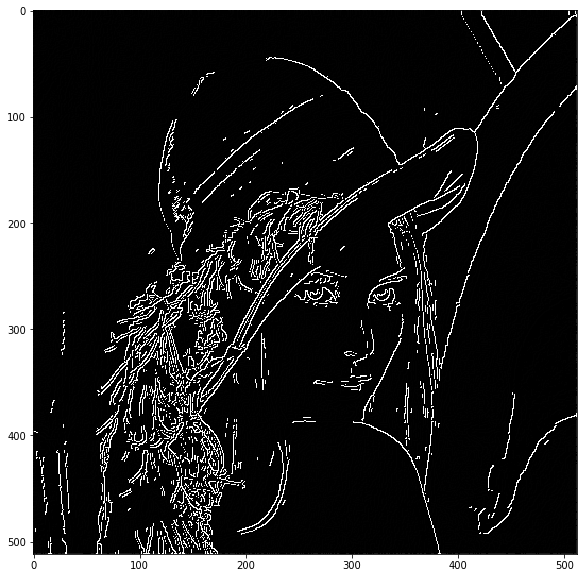

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(edged_img, cmap="gray")